In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest




import ast
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from keras.models import Sequential
from autoencoder_module import AutoEncoder
from Data import train_test_split_count_matrix_baseline, count_matrix #, train_test_split_count_matrix_for_LSTM_easier_padding, train_test_split_count_matrix_for_LSTM, create_arrays_from_df_easier_v1
import h5py
from Analysis import roc_curve_for_analysis
from math import ceil
from typing import Tuple
from tensorflow.keras.layers import Dense, GRU, Lambda, Flatten
import tensorflow.keras as keras


In [14]:
def sequence_for_embedding(event_list, n, length_of_sequence: int=50) -> np.array:
    sequence = []
    i = 0
    for event in event_list:
        sequence.append(int(event[1:]) - 1)
    if len(sequence) < length_of_sequence:
        for i in range(length_of_sequence-len(sequence)):
            sequence.append(n)
        return np.array(sequence)
    else:
        return np.array(sequence[0:length_of_sequence])

def create_arrays_from_sequences(data_df:pd.DataFrame) -> Tuple[np.array, np.array]:
    X, y = [], []
    for _, row in data_df.iterrows():
        seq = row['Event_sequences']
        label = row['label']
        X.append(seq)
        y.append(label)
    return X, y


def create_sequences_for_embedding(path: str, length_of_sequences: int, test_size: float=0.2, random_state: int=42):
    #Loading in the data
    data_df = pd.read_csv(path)
    #Converting the labels to binary numbers, 0 for success, 1 for failure
    mask = data_df['Final Label'] == 'Success'
    data_df.loc[mask, 'label'] = 0
    data_df.loc[~mask, 'label'] = 1
    #I do not need the index column
    data_df = data_df.reset_index(drop=True)

    data_df['Events']  = data_df['New Event ID'].apply(ast.literal_eval)
    #Calculating the maximum value of the En type events
    max_n = max(int(e[1:]) for sublist in data_df['Events'] for e in sublist)
    data_df['Event_sequences'] = data_df['Events'].apply(lambda x: sequence_for_embedding(x, max_n, length_of_sequences))
    data_df.drop(columns=['Unnamed: 0', 'BlockId', 'New Event ID', 'Final Label', 'Events'], inplace=True)
    #Separate the dataframes based on the label and perform the train_test_split
    success_df = data_df.loc[data_df['label'] == 0].copy(deep=True)
    fail_df = data_df.loc[data_df['label'] == 1].copy(deep=True)
    train_success_df, test_success_df = train_test_split(success_df, test_size=test_size, shuffle=True, random_state=random_state)
    train_fail_df, test_fail_df = train_test_split(fail_df, test_size=test_size, shuffle=True, random_state=random_state)
    #Now concatenate the dataframes
    train_df = pd.concat([train_success_df, train_fail_df], ignore_index=True).sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_df = pd.concat([test_success_df, test_fail_df], ignore_index=True).sample(frac=1, random_state=random_state).reset_index(drop=True)
    X_train, y_train = create_arrays_from_sequences(train_df)
    X_test, y_test = create_arrays_from_sequences(test_df)
    return X_train, X_test, y_train, y_test
path = '../Data/HDFS_v1/Processed_data/processed_labeled_data.csv'
X_train, X_test, y_train, y_test = create_sequences_for_embedding(path, 50)

In [ ]:
result_df.to_csv('../Data/HDFS_v1/Processed_data/log_templates_embeddings_GPT.csv', index=False)

(115013, 50)

In [13]:
list1 = ['E1']*100
list2 = list1[0:25]
modified_list1 = sequence_for_embedding(list1, 48, 50)
modified_list2 = sequence_for_embedding(list2, 48, 50)
modified_list2[25:]

array([48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48])

In [2]:
path = '../Data/HDFS_v1/Processed_data/processed_labeled_data.csv'
data_df = pd.read_csv(path)
#Converting the labels to binary numbers, 0 for success, 1 for failure
mask = data_df['Final Label'] == 'Success'
data_df.loc[mask, 'label'] = 0
data_df.loc[~mask, 'label'] = 1
#I do not need the index column
data_df = data_df.reset_index(drop=True)

data_df['Events']  = data_df['New Event ID'].apply(ast.literal_eval)
#Calculating the maximum value of the En type events
max_n = max(int(e[1:]) for sublist in data_df['Events'] for e in sublist)
max_n

48

In [2]:
def create_arrays_from_df_easier_v2(data_df: pd.DataFrame, length_of_matrices: int=50) -> Tuple[np.array, np.array]:
    X, y = [], []
    for _, row in data_df.iterrows():
        seq = row['Event_Count_Matrix']
        label = row['label']
        if seq.shape[0] < length_of_matrices:
            helper_matrix = np.zeros((length_of_matrices, seq.shape[1]))
            helper_matrix[:seq.shape[0]] = seq
            helper_matrix[seq.shape[0]:] = seq[-1]
        if seq.shape[0] >= length_of_matrices:
            helper_matrix = seq[:length_of_matrices]
        X.append(helper_matrix)
        y.append(label)
    return np.array(X), np.array(y)



def train_test_split_count_matrix_for_LSTM_easier_padding(path: str, length_of_matrices: int, version: int=1,sequence_col: str = 'Event_Count_Matrix', label_col: str='label', test_size: float=0.2, random_state: int=42):
    #Loading in the data
    data_df = pd.read_csv(path)
    #Converting the labels to binary numbers, 0 for success, 1 for failure
    mask = data_df['Final Label'] == 'Success'
    data_df.loc[mask, 'label'] = 0
    data_df.loc[~mask, 'label'] = 1
    #I do not need the index column
    data_df = data_df.reset_index(drop=True)

    data_df['Events']  = data_df['New Event ID'].apply(ast.literal_eval)
    #Calculating the maximum value of the En type events
    max_n = max(int(e[1:]) for sublist in data_df['Events'] for e in sublist)
    data_df['Event_Count_Matrix'] = data_df['Events'].apply(lambda x: count_matrix(x, max_n))
    data_df.drop(columns=['Unnamed: 0', 'BlockId', 'New Event ID', 'Final Label', 'Events'], inplace=True)

    #Separate the dataframes based on the label and perform the train_test_split
    success_df = data_df.loc[data_df['label'] == 0].copy(deep=True)
    fail_df = data_df.loc[data_df['label'] == 1].copy(deep=True)
    train_success_df, test_success_df = train_test_split(success_df, test_size=test_size, shuffle=True, random_state=random_state)
    train_fail_df, test_fail_df = train_test_split(fail_df, test_size=test_size, shuffle=True, random_state=random_state)
    #Now concatenate the dataframes
    train_df = pd.concat([train_fail_df[:10], train_success_df[:10]], ignore_index=True)
    test_df = pd.concat([test_fail_df[:10],test_success_df[:10]], ignore_index=True)
    #Now let's perform the matrix creating magic
    if version == 1:
        X_train, y_train = create_arrays_from_df_easier_v1(train_df, length_of_matrices)
        X_test, y_test = create_arrays_from_df_easier_v1(test_df, length_of_matrices)
    if version == 2:
        X_train, y_train = create_arrays_from_df_easier_v2(train_df, length_of_matrices)
        X_test, y_test = create_arrays_from_df_easier_v2(test_df, length_of_matrices)
    
    return X_train, X_test, y_train, y_test
path = '../Data/HDFS_v1/Processed_data/processed_labeled_data.csv'
length_of_matrices = 50
X_train, X_test, y_train, y_test = train_test_split_count_matrix_for_LSTM_easier_padding(path, length_of_matrices, version=2)


In [8]:
np.shape(X_train[0])

(50, 48)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, TimeDistributed, GlobalAveragePooling1D, Flatten, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model
from keras.layers import Lambda, Flatten, Input
from tensorflow.math import reduce_max, reduce_mean
from tensorflow.keras.metrics import Precision, Recall


input_layer = Input(shape=(50,48))
gru = GRU(40, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.01))(input_layer)
timedistributed = TimeDistributed(Dense(1, activation='sigmoid'))(gru)
flatten=Flatten()(timedistributed)
#max_val = Lambda(lambda x: reduce_max(x, axis=1))(flatten)
#mean_val = Lambda(lambda x: reduce_mean(x, axis=1))(flatten)
#difference_layer = Lambda(lambda x: x[0]-x[1])([max_val, mean_val])
model = Model(inputs=input_layer, outputs=flatten)

model.load_weights('../Models/regularizedgru_lambda_1.keras')
model.summary()
sample = np.expand_dims(X_test[0], axis=0)
result = model.predict(sample)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50, 40)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 1)          │            41 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,841 (42.35 KB)

 Trainable params: 10,841 (42.35 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(10, 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


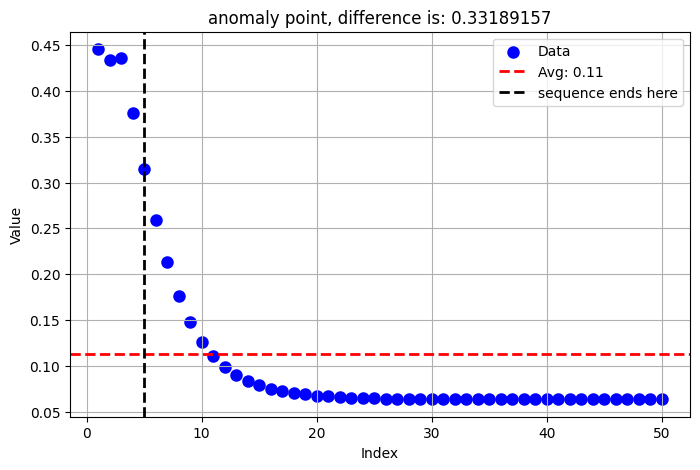

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


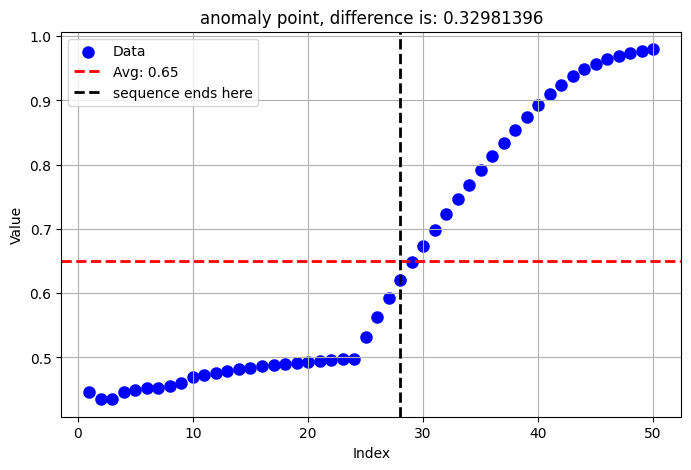

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


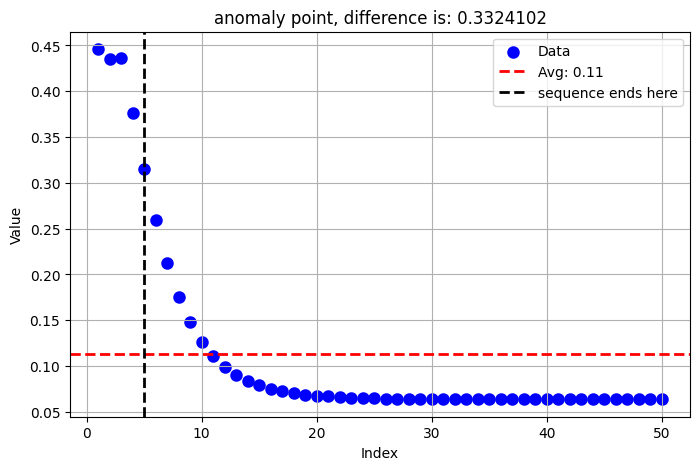

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


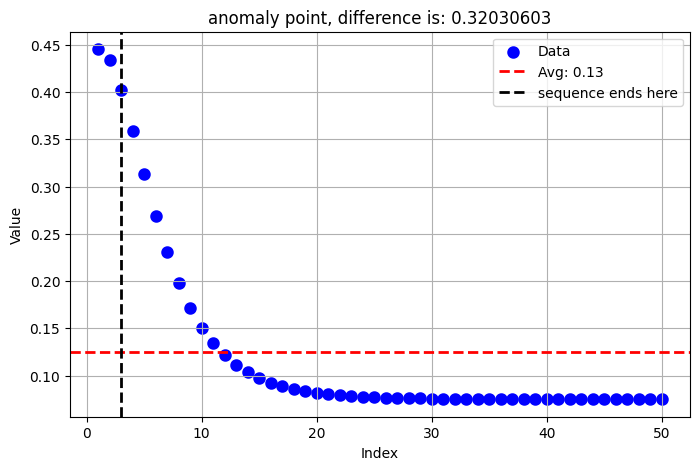

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


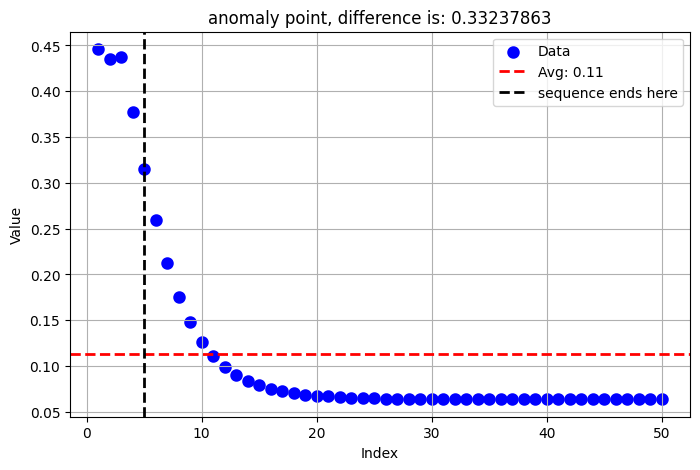

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


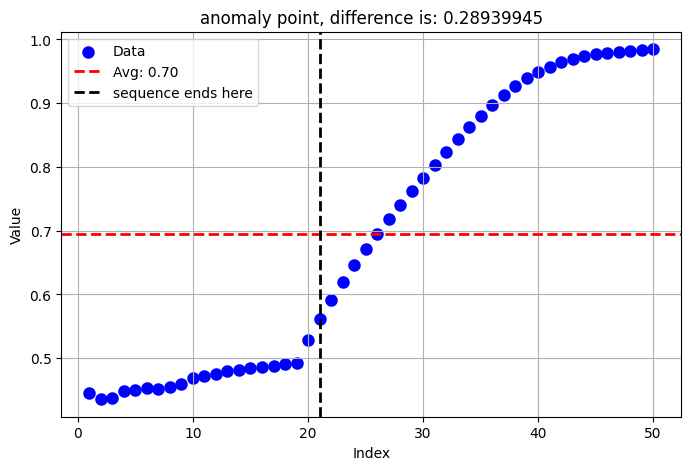

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


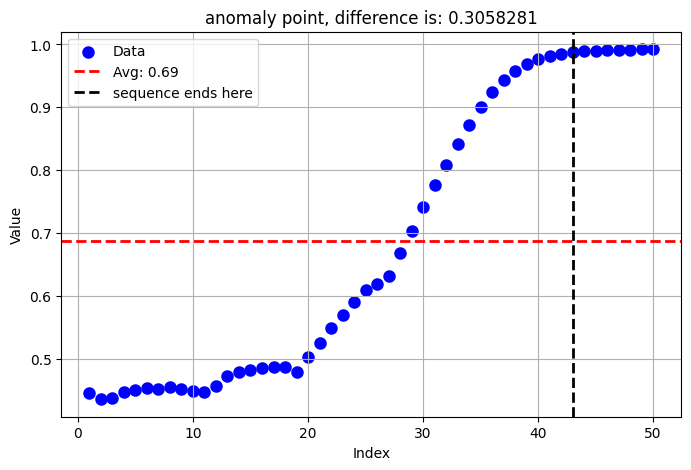

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


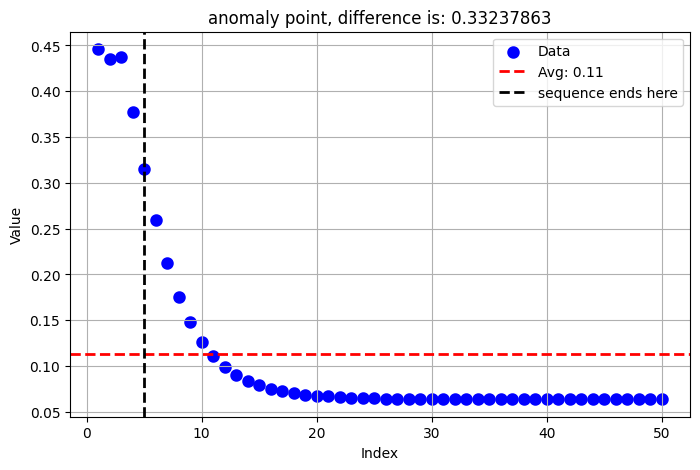

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


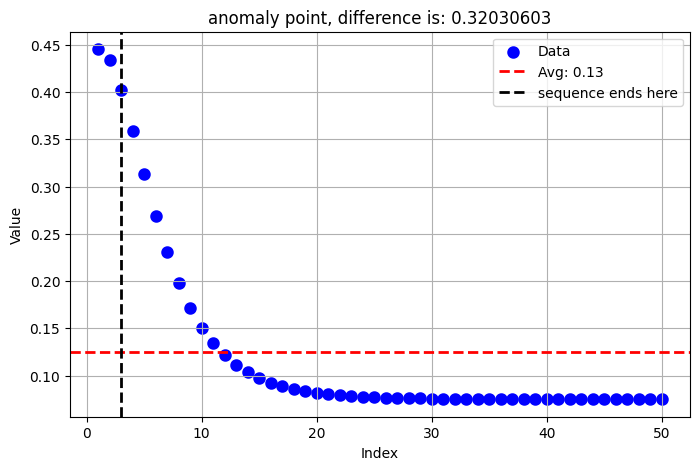

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


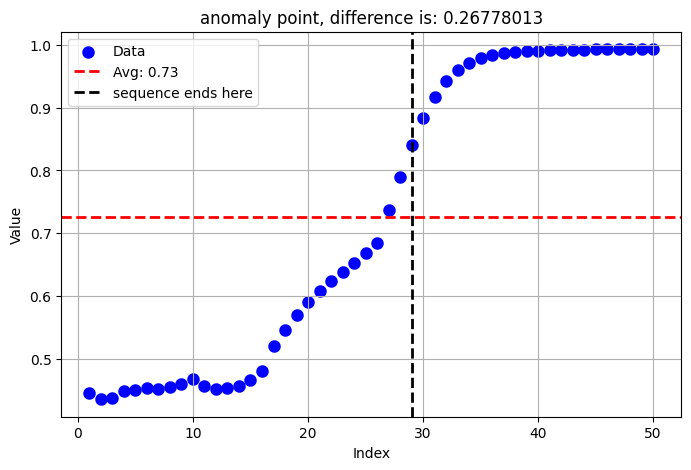

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


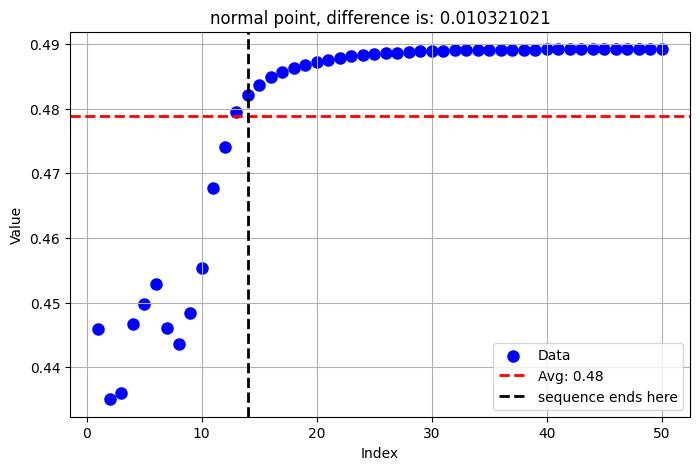

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


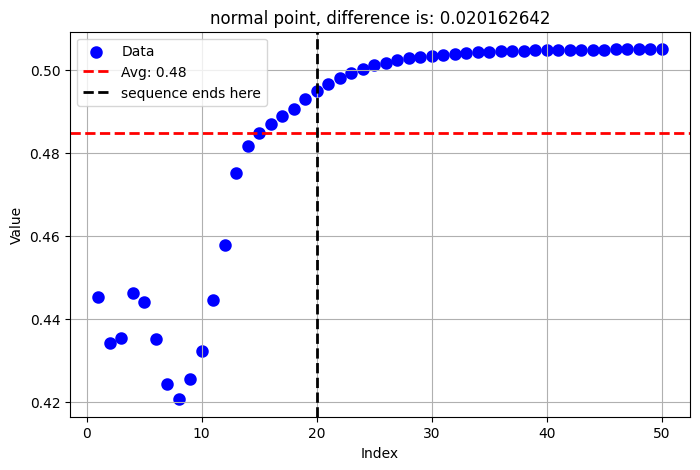

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


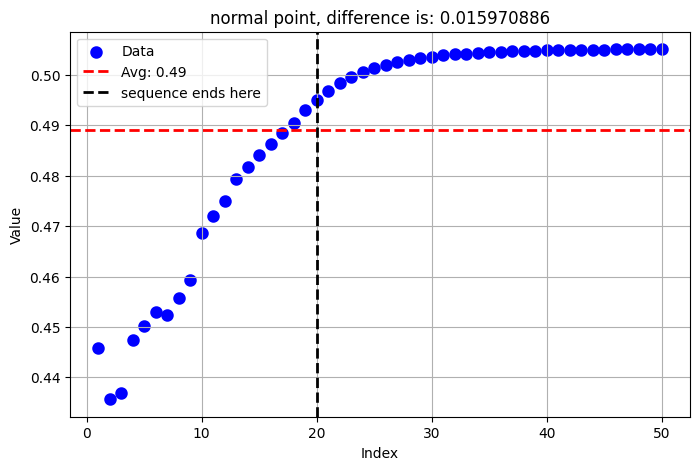

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


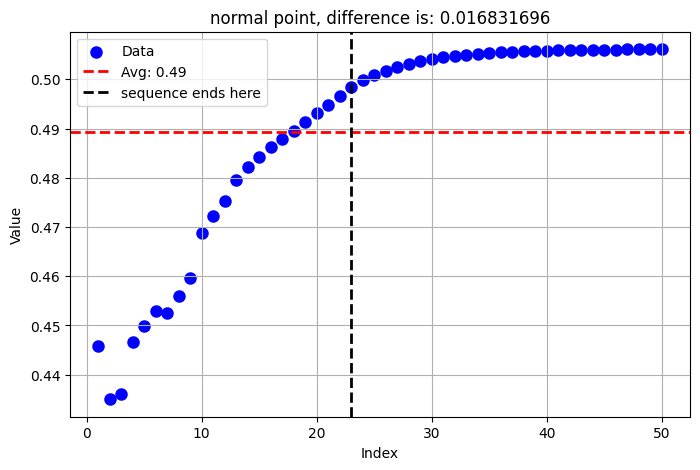

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


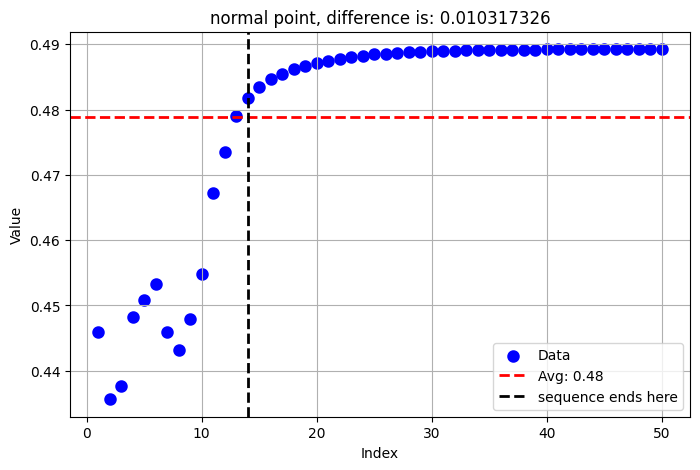

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


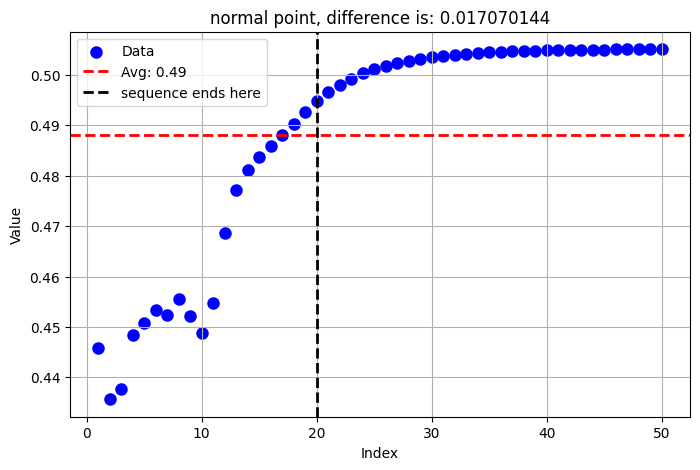

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


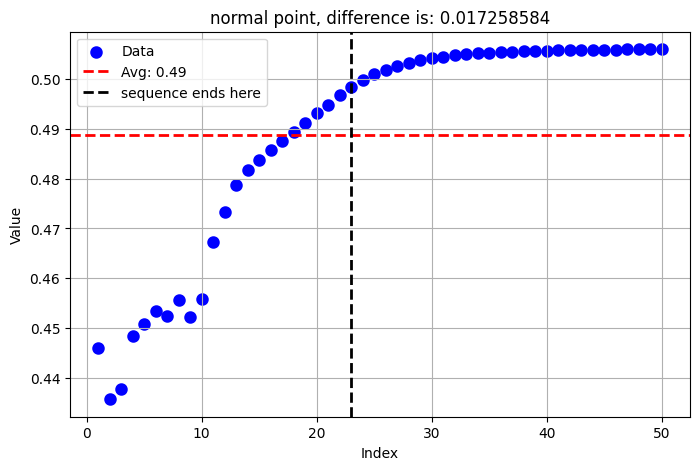

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


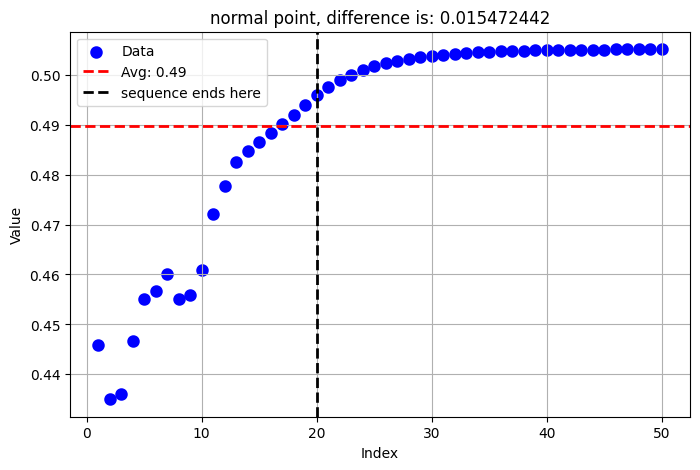

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


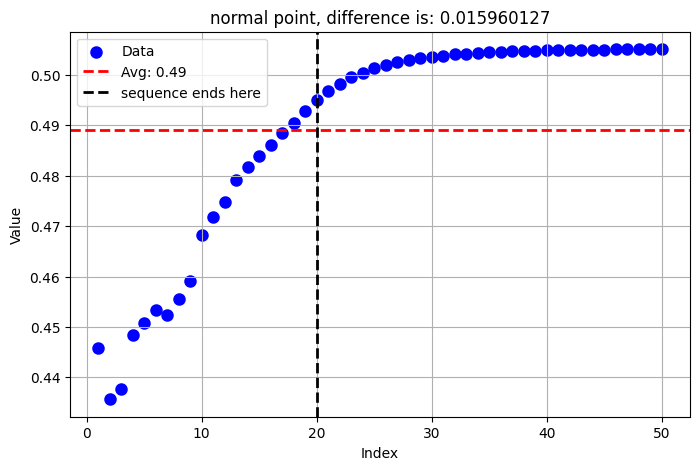

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


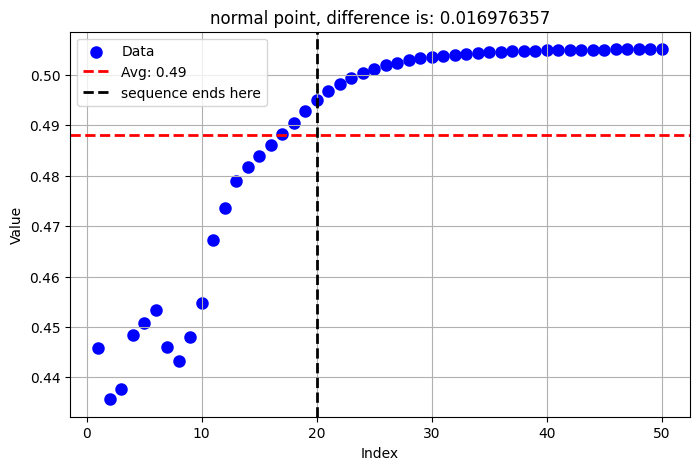

In [6]:
import matplotlib.pyplot as plt
def find_padding_start(arr):
    """
    Finds the index of the first row where padding starts in a numpy array.
    
    Args:
        arr (np.ndarray): A 2D numpy array with shape (50, 48), where padding may have occurred.
    
    Returns:
        int: The index of the first row where padding starts.
        None: If no padding is found.
    """
    for i in range(1, arr.shape[0]):
        if np.array_equal(arr[i], arr[i-1]):  # Compare the current row with the previous one
            return i  # Return the index where padding starts
    
    return None  # Return None if no padding is detected

def plot_timedistributed_sequence(model, data_point, label):
    sample = np.expand_dims(data_point, axis=0)
    padding_starts_at = find_padding_start(data_point)
    result = model.predict(sample)
    result_reshaped = result.flatten()
    avg_value = np.mean(result)
    max_value = np.max(result)
    x_values = np.arange(1, 51)  # X-axis: Integers from 1 to 50

    # Create the plot
    plt.figure(figsize=(8, 5))
    plt.scatter(x_values, result_reshaped, color='blue', linewidth=3, label="Data")
    plt.axhline(y=avg_value, color='red', linewidth=2, linestyle="--", label=f"Avg: {avg_value:.2f}")
    if padding_starts_at != None:
        plt.axvline(x = padding_starts_at+1, color='black', linewidth=2, linestyle = '--', label="sequence ends here")
    # Labels and title
    plt.xlabel("Index")
    plt.ylabel("Value")
    if label == 1:
        plt.title("anomaly point, difference is: " + str(max_value-avg_value))
    else:
        plt.title("normal point, difference is: " + str(max_value-avg_value))
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()
for i in range(20):
    plot_timedistributed_sequence(model, X_test[i], y_test[i])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 50, 40)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 50, 1)          │            41 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,894 (42.56 KB)

 Trainable params: 10,892 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

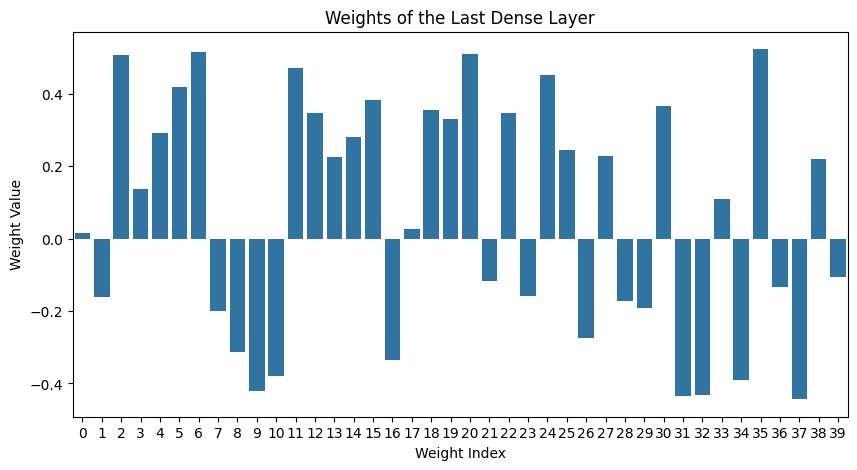

In [ ]:
import seaborn as sns

model = load_model('../Models/regularizedgru_lambda_1.keras')
model.summary()
dense_layer = model.get_layer("time_distributed_3")  # Get the layer by name
weights, biases = dense_layer.get_weights()  # Extract weights and biases

# Plot the weights as a bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(weights.flatten())), y=weights.flatten())
plt.xlabel("Weight Index")
plt.ylabel("Weight Value")
plt.title("Weights of the Last Dense Layer")
plt.show()

In [4]:
def create_arrays_from_df_easier_v2(data_df: pd.DataFrame, length_of_matrices: int=50) -> Tuple[np.array, np.array]:
    X, y = [], []
    for _, row in data_df.iterrows():
        seq = row['Event_Count_Matrix']
        label = row['label']
        if seq.shape[0] < length_of_matrices:
            helper_matrix = np.zeros((length_of_matrices, seq.shape[1]))
            helper_matrix[:seq.shape[0]] = seq
            helper_matrix[seq.shape[0]:] = seq[-1]
        if seq.shape[0] >= length_of_matrices:
            helper_matrix = seq[:length_of_matrices]
        X.append(helper_matrix)
        y.append(label)
    return np.array(X), np.array(y)

def train_test_split_count_matrix_for_LSTM_easier_padding(path: str, length_of_matrices: int, version: int=1,sequence_col: str = 'Event_Count_Matrix', label_col: str='label', test_size: float=0.2, random_state: int=42):
    #Loading in the data
    data_df = pd.read_csv(path)
    #Converting the labels to binary numbers, 0 for success, 1 for failure
    mask = data_df['Final Label'] == 'Success'
    data_df.loc[mask, 'label'] = 0
    data_df.loc[~mask, 'label'] = 1
    #I do not need the index column
    data_df = data_df.reset_index(drop=True)

    data_df['Events']  = data_df['New Event ID'].apply(ast.literal_eval)
    #Calculating the maximum value of the En type events
    max_n = max(int(e[1:]) for sublist in data_df['Events'] for e in sublist)
    data_df['Event_Count_Matrix'] = data_df['Events'].apply(lambda x: count_matrix(x, max_n))
    data_df.drop(columns=['Unnamed: 0', 'BlockId', 'New Event ID', 'Final Label', 'Events'], inplace=True)

    #Separate the dataframes based on the label and perform the train_test_split
    success_df = data_df.loc[data_df['label'] == 0].copy(deep=True)
    fail_df = data_df.loc[data_df['label'] == 1].copy(deep=True)
    train_success_df, test_success_df = train_test_split(success_df, test_size=test_size, shuffle=True, random_state=random_state)
    train_fail_df, test_fail_df = train_test_split(fail_df, test_size=test_size, shuffle=True, random_state=random_state)
    #Now concatenate the dataframes
    train_df = pd.concat([train_success_df, train_fail_df], ignore_index=True)
    test_df = pd.concat([test_success_df, test_fail_df], ignore_index=True)
    #Now let's perform the matrix creating magic
    if version == 1:
        X_train, y_train = create_arrays_from_df_easier_v1(train_df, length_of_matrices)
        X_test, y_test = create_arrays_from_df_easier_v1(test_df, length_of_matrices)
    if version == 2:
        X_train, y_train = create_arrays_from_df_easier_v2(train_df[0:10], length_of_matrices)
        X_test, y_test = create_arrays_from_df_easier_v2(test_df[0:10], length_of_matrices)
    
    return X_train, X_test, y_train, y_test

In [5]:
path = '../Data/HDFS_v1/Processed_data/processed_labeled_data.csv'
length_of_matrices = 50
X_train, X_test, y_train, y_test = train_test_split_count_matrix_for_LSTM_easier_padding(path, length_of_matrices, version=2)

In [7]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, Flatten, TimeDistributed, MaxPool1D, Lambda, Input, Bidirectional, Dropout
from tensorflow.math import reduce_max, reduce_mean
#import tensorflow_probability as tfp
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras import Model
from keras.optimizers import SGD
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


input_layer = Input(shape=(50,48))
gru = GRU(10, return_sequences=True, activation='tanh')(input_layer)
timedistributed = TimeDistributed(Dense(1, activation='sigmoid'))(gru)
flatten=Flatten()(timedistributed)
max_val = Lambda(lambda x: reduce_max(x, axis=1))(flatten)
mean_val = Lambda(lambda x: reduce_mean(x, axis=1))(flatten)
difference_layer = Lambda(lambda x: x[0]-x[1])([max_val, mean_val])
model = Model(inputs=input_layer, outputs=difference_layer)
model.compile(loss='binary_crossentropy', optimizer='adam')

early_stopping = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='../Models/regularizedgrul4dropout.keras', save_best_only=True, verbose=1)

model.summary()

history = model.fit(x=X_train,
                    y=y_train,
                    epochs=5,
                    validation_split=0.3,
                    batch_size=32,
                    callbacks=[checkpointer, early_stopping])

model.load_weights('../Models/regularizedgrul4dropout.keras')

result = model.predict(X_test)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 48)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 50, 10)    │      1,800 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 50, 1)     │         11 │ gru[0][0]         │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None)            │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None)            │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None)            │          0 │ lambda[0][0],     │
│                     │                   │            │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,811 (7.07 KB)

 Trainable params: 1,811 (7.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0782
Epoch 1: val_loss improved from inf to 0.06408, saving model to ../Models/regularizedgrul4dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0782 - val_loss: 0.0641
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0752
Epoch 2: val_loss improved from 0.06408 to 0.06161, saving model to ../Models/regularizedgrul4dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0752 - val_loss: 0.0616
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0723
Epoch 3: val_loss improved from 0.06161 to 0.05916, saving model to ../Models/regularizedgrul4dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0723 - val_loss: 0.0592
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0693
Epoch 4: val_loss improved from 0.05916 to 0.05672, saving model to ../Models/regularizedgrul4dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0693 - val_loss: 0.0567
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━

In [14]:
for i in range(len(result)):
    print(result[i], y_test[i])

0.04745245 0.0
0.037641406 0.0
0.064737916 0.0
0.04458773 0.0
0.047012687 0.0
0.062342703 0.0
0.036257684 0.0
0.051417828 0.0
0.06499463 0.0
0.055454493 0.0


numpy.ndarray